ERROR:visual_behavior.translator.foraging2.extract:intervalsms record appears to be missing entries
/home/dougo/Code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/running_processing.py:367: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  "value removed\n", UserWarning, stacklevel=1)
/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/running_processing.py:15: RuntimeWarning: Mean of empty slice
  dxdt = np.nanmean(dxdt, axis=0)


Text(0, 0.5, 'speed (cm/s)')

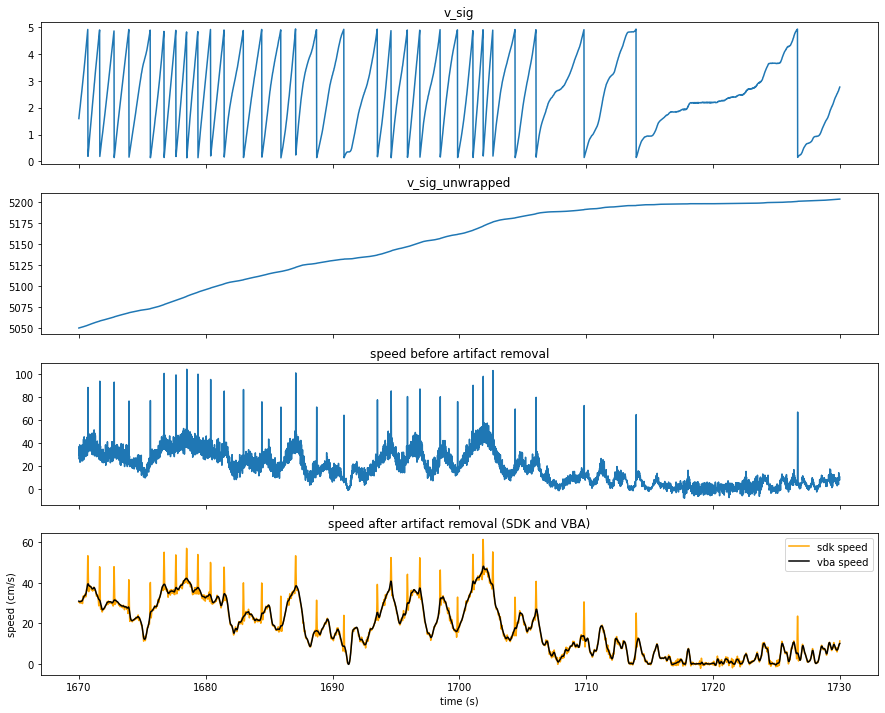

In [5]:
from allensdk.brain_observatory.behavior.behavior_ophys_session import BehaviorOphysSession
import matplotlib.pyplot as plt
import visual_behavior.database as db
import pandas as pd
from visual_behavior.translator.foraging2 import data_to_change_detection_core
import visual_behavior.encoder_processing.running_data_smoothing as running_data_smoothing

# open the SDK session object for a given experiment
ophys_experiment_id = 851093291
session = BehaviorOphysSession.from_lims(ophys_experiment_id)

# get the running data directly from the PKL file to compare the VBA implementation of running smoothing
osid = db.lims_query('select ophys_session_id from ophys_experiments where id = {}'.format(ophys_experiment_id))
pkl_path = db.get_pkl_path(osid, 'ophys_session_id')
data= pd.read_pickle(pkl_path)
core_data = data_to_change_detection_core(data)

# set the 'timestamps' column in core_data['running'] to be the SDK timestamps
core_data['running']['timestamps'] = session.running_data_df.index

# run the PKL running data through the VBA smoothing method
processed_running_df = running_data_smoothing.process_encoder_data(
    core_data['running'], 
    time_column='timestamps', 
    v_max='v_sig_max', 
    filter_cutoff_frequency=4, 
    remove_outliers_at_wraps=True, 
    zscore_thresold=5
)

# make a plot
t0 = 1670
t1 = 1730
fig, ax = plt.subplots(4,1,figsize=(15,12), sharex=True)
ax[0].plot(
    processed_running_df.query('timestamps >= @t0 and timestamps <= @t1')['timestamps'],
    processed_running_df.query('timestamps >= @t0 and timestamps <= @t1')['v_sig'],
)
ax[0].set_title('v_sig')

ax[1].plot(
    processed_running_df.query('timestamps >= @t0 and timestamps <= @t1')['timestamps'],
    processed_running_df.query('timestamps >= @t0 and timestamps <= @t1')['v_sig_unwrapped'],
)
ax[1].set_title('v_sig_unwrapped')

ax[2].plot(
    processed_running_df.query('timestamps >= @t0 and timestamps <= @t1')['timestamps'],
    processed_running_df.query('timestamps >= @t0 and timestamps <= @t1')['speed_raw_pre_wrap_correction'],
)
ax[2].set_title('speed before artifact removal')

ax[3].plot(
    session.running_data_df.query('timestamps >= @t0 and timestamps <= @t1')['speed'],
    color='orange'
)
ax[3].plot(
    processed_running_df.query('timestamps >= @t0 and timestamps <= @t1')['timestamps'],
    processed_running_df.query('timestamps >= @t0 and timestamps <= @t1')['speed'],
    color='black'
)
ax[3].set_title('speed after artifact removal (SDK and VBA)')
ax[3].legend(['sdk speed','vba speed'])

ax[3].set_xlabel('time (s)')
ax[3].set_ylabel('speed (cm/s)')

In [6]:
import allensdk

In [7]:
allensdk.__version__

'2.3.2'